In [169]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline

from itertools import accumulate

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, \
    f1_score, make_scorer, PrecisionRecallDisplay, RocCurveDisplay

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, \
    CondensedNearestNeighbour, TomekLinks

import sys
import joblib
import six
import sklearn.ensemble._base
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.six.moves'] = six.moves
sys.modules['sklearn.ensemble.base'] = sklearn.ensemble._base
from costcla.models import CostSensitiveDecisionTreeClassifier as CSDTC
from costcla.metrics import savings_score

In [2]:
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_confusion_mtx(cm: 'confusion matrix', classes, 
                       figsize = (3,3), binary = True):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    color = sns.dark_palette("#69d", reverse=True, as_cmap=True)
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = color, cbar = False, ax = ax)
    
    plt.xlabel('Predicted Class', fontsize = 14)
    plt.ylabel('Actual Class', fontsize = 14)
    plt.xticks(ax.get_xticks(), classes)
    plt.yticks(ax.get_yticks(), classes)
    if binary:
        plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')

In [4]:
# Credits to prof. R. Guidotti

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [342]:
def plot_gains_curve(y_true:'np array', y_pred_proba:'np array', label = None):
    idx = np.argsort(y_pred_proba)[::-1]
    acc = list(accumulate(y_true[idx]))
    plt.plot(acc, label = label)
    n_samples = len(acc)
    plt.plot([0,n_samples], [0, acc[-1]], 'k--')
    xticks = np.linspace(0, n_samples, 6)
    yticks = np.linspace(0, acc[-1], 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    y_lab = np.around(np.linspace(0, 1, 6), decimals = 1) 
    plt.xticks(xticks, x_lab)
    plt.yticks(yticks, y_lab)
    plt.xlabel('% of samples', fontsize = 16)
    plt.ylabel('Gain', fontsize = 16)

In [343]:
def plot_lift(y_true:'np array', y_pred_proba:'np array', label = None):
    n_samples = len(y_true)
    idx = np.argsort(y_pred_proba)[::-1]
    cum_trues = list(accumulate(y_true[idx]))
    perc_trues = map(lambda x: x / cum_trues[-1], cum_trues)   
    cum_samples = range(1, n_samples + 1)
    perc_samples = map(lambda x: x / n_samples, cum_samples)  
    lift = list(map(lambda x, y: x / y, perc_trues, perc_samples))    
    plt.plot(lift, label = label)
    plt.axhline(y = 1, ls = '--', color = 'k',)
    plt.xlabel('% of samples', fontsize = 16)
    plt.ylabel('Lift', fontsize = 16)

## Data Preparation

In [5]:
X_train = pd.read_fwf(".\X_train.txt", header = None)
X_test = pd.read_fwf(".\X_test.txt", header = None)
y_train = pd.read_fwf(".\y_train.txt", header = None) # df, not a series
y_test = pd.read_fwf(".\y_test.txt", header = None) # df, not a series

In [6]:
with open("features.txt") as f:
    lines = f.read().splitlines() 

In [7]:
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name
    
features

{0: 'tBodyAcc-mean()-X',
 1: 'tBodyAcc-mean()-Y',
 2: 'tBodyAcc-mean()-Z',
 3: 'tBodyAcc-std()-X',
 4: 'tBodyAcc-std()-Y',
 5: 'tBodyAcc-std()-Z',
 6: 'tBodyAcc-mad()-X',
 7: 'tBodyAcc-mad()-Y',
 8: 'tBodyAcc-mad()-Z',
 9: 'tBodyAcc-max()-X',
 10: 'tBodyAcc-max()-Y',
 11: 'tBodyAcc-max()-Z',
 12: 'tBodyAcc-min()-X',
 13: 'tBodyAcc-min()-Y',
 14: 'tBodyAcc-min()-Z',
 15: 'tBodyAcc-sma()',
 16: 'tBodyAcc-energy()-X',
 17: 'tBodyAcc-energy()-Y',
 18: 'tBodyAcc-energy()-Z',
 19: 'tBodyAcc-iqr()-X',
 20: 'tBodyAcc-iqr()-Y',
 21: 'tBodyAcc-iqr()-Z',
 22: 'tBodyAcc-entropy()-X',
 23: 'tBodyAcc-entropy()-Y',
 24: 'tBodyAcc-entropy()-Z',
 25: 'tBodyAcc-arCoeff()-X,1',
 26: 'tBodyAcc-arCoeff()-X,2',
 27: 'tBodyAcc-arCoeff()-X,3',
 28: 'tBodyAcc-arCoeff()-X,4',
 29: 'tBodyAcc-arCoeff()-Y,1',
 30: 'tBodyAcc-arCoeff()-Y,2',
 31: 'tBodyAcc-arCoeff()-Y,3',
 32: 'tBodyAcc-arCoeff()-Y,4',
 33: 'tBodyAcc-arCoeff()-Z,1',
 34: 'tBodyAcc-arCoeff()-Z,2',
 35: 'tBodyAcc-arCoeff()-Z,3',
 36: 'tBodyAcc-arCoeff

In [8]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [9]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [10]:
y_train_mapped = y_train[0].map(activities)

## Imbalance the dataset

Since point 1.4 of the project guidelines impose to perform a BINARY classification, there are only two alternatives:

- 1) relabel the activities in movement and stationary activities end perform binary classification.
- 2) select two classes, imbalance one of them, and perform a binary classification with them;

but:
- 3) We can also try to perform a multiclass classification by unbalancing one or more classes.

### 1)

In [131]:
# train set: movement and stationary activities 

mov_idx = y_train[0][y_train[0] < 4].index
sta_idx = y_train[0][y_train[0] > 3].index
y1_train = y_train.copy()

In [132]:
y1_train.loc[mov_idx, :] = 'Movement'
y1_train.loc[sta_idx, :] = 'Stationary'

In [133]:
# test set: movement and stationary activities
act_map = dict(zip(activities, ['Movement']*3 + ['Stationary']*3))
y1_test = y_test[0].map(act_map)
y1_test

0       Stationary
1       Stationary
2       Stationary
3       Stationary
4       Stationary
           ...    
2942      Movement
2943      Movement
2944      Movement
2945      Movement
2946      Movement
Name: 0, Length: 2947, dtype: object

In [134]:
np.unique(y1_train, return_counts = True)

(array(['Movement', 'Stationary'], dtype=object),
 array([3285, 4067], dtype=int64))

Let's try to unbalance the Movement class. Fixed the cardinality of stationary activities, in order to obtain an unbalanced configuration of 96-4% we have to solve: $\dfrac{x}{4067+x} = 0.04,\; x > 0$. That is, $x = 169.458$.

In [21]:
generator = np.random.default_rng(seed = 5)

In [ ]:
mov_sample_idx = generator.choice(mov_idx, 169, replace = False)

In [136]:
new_idx = np.sort(np.hstack((mov_sample_idx, sta_idx)))
X1_train = X_train.loc[new_idx, :]
y1_train = y1_train.loc[new_idx, :]

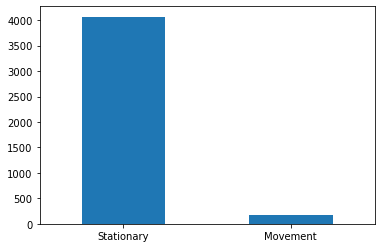

In [137]:
y1_train[0].value_counts().plot.bar(rot = 0)
plt.show()

In [138]:
clf = DTC().fit(X1_train, y1_train.values.flatten())
y_pred = clf.predict(X_test)

In [139]:
print(classification_report(y1_test, y_pred))

              precision    recall  f1-score   support

    Movement       1.00      1.00      1.00      1387
  Stationary       1.00      1.00      1.00      1560

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947



There is no need to apply any classification imbalanced techniques because Movement and Stationary are well separated activities.

### 2)

Let's try to perform a binary classification between WALKING UPSTAIRS and WALKING DOWNSTAIRS

In [11]:
# let's select WALKING UPSTAIRS and WALKING DOWNSTAIRS in the train set

mask = (y_train[0] == 2) | (y_train[0] == 3)
idx = y_train[0][mask].index
X2_train = X_train.loc[idx, :]
y2_train = y_train.loc[idx, :]

X2_train.shape, y2_train.shape

((2059, 561), (2059, 1))

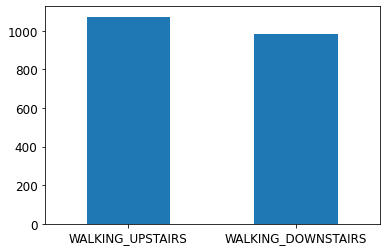

In [12]:
y2_train[0].value_counts().plot.bar(rot = 0)
ax = plt.gca()
xticks = ax.get_xticks()
plt.xticks(xticks, ['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])
plt.show()

In [13]:
np.unique(y2_train, return_counts = True)

(array([2, 3], dtype=int64), array([1073,  986], dtype=int64))

The two classes are balanced

In [14]:
# let's select WALKING UPSTAIRS and WALKING DOWNSTAIRS in the test set

mask = (y_test[0] == 2) | (y_test[0] == 3)
idx = y_test[0][mask].index
X2_test = X_test.loc[idx, :]
y2_test = y_test.loc[idx, :]

X2_test.shape, y2_test.shape

((891, 561), (891, 1))

In [15]:
clf = DTC().fit(X2_train, y2_train.values.flatten())
y_pred = clf.predict(X2_test)

In [16]:
print(classification_report(y2_test, y_pred))

              precision    recall  f1-score   support

           2       0.90      0.86      0.88       471
           3       0.85      0.90      0.87       420

    accuracy                           0.88       891
   macro avg       0.88      0.88      0.88       891
weighted avg       0.88      0.88      0.88       891



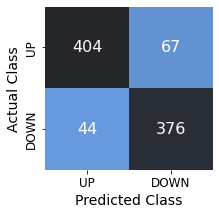

In [18]:
cm = confusion_matrix(y2_test, y_pred, labels = clf.classes_)
plot_confusion_mtx(cm, ['UP', 'DOWN'], binary = False)

The classifier has good performances though we built a full tree without tuning the hyperparameters. Now let's try to unbalance the WALKING DOWNSTAIRS class.

---

In [19]:
y2_train[0].value_counts()

2    1073
3     986
Name: 0, dtype: int64

In [22]:
'''In order to obtain a 96-4% proportion we need 
to sample 44 WALKING_DOWNSTAIRS instances
'''

walk_down_idx = y2_train[0][y2_train[0] == 3].index
walk_up_idx = y2_train[0][y2_train[0] == 2].index
sampled_idx = generator.choice(walk_down_idx, 44, replace = False)
mask = np.sort(np.hstack((sampled_idx, walk_up_idx)))
X2_train_imb = X2_train.loc[mask, :]
y2_train_imb = y2_train.loc[mask, :]
X2_train_imb.shape, y2_train_imb.shape

((1117, 561), (1117, 1))

In [23]:
'''
relabel WALKING DOWNSTAIRS as 1 (positive class) 
and WALKING UPSTAIRS as 0 since the grid search raise a label error
'''

y2_train_imb = y2_train_imb[0].map(lambda x: 1 if x == 3 else 0)
y2_test = y2_test[0].map(lambda x: 1 if x == 3 else 0)
y2_train_imb.value_counts(), '\n\n', y2_test.value_counts()

(0    1073
 1      44
 Name: 0, dtype: int64,
 '\n\n',
 0    471
 1    420
 Name: 0, dtype: int64)

In [24]:
# imbalance, w/o tuning

dtc = DTC().fit(X2_train_imb, y2_train_imb.values)
y2_pred_imb = dtc.predict(X2_test)

In [25]:
print(classification_report(y2_test, y2_pred_imb))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       471
           1       0.96      0.67      0.79       420

    accuracy                           0.83       891
   macro avg       0.86      0.82      0.82       891
weighted avg       0.86      0.83      0.83       891



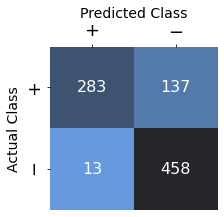

In [26]:
cm = confusion_matrix(y2_test, y2_pred_imb, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [259]:
# imbalance, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10, 
                           scoring = 'f1') # f1 is a good measure with class imbalance

In [260]:
grid_search.fit(X2_train_imb, y2_train_imb.values)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='f1')

In [261]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 25, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 30, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 35, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score: 0.839 (std: 0.140)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 40, 'min_samples_leaf': 45}

Model with rank: 1
Mean validation score:

In [29]:
# I did not save the classifier 

dtc_tuned = DTC(max_depth=4, max_leaf_nodes=10, 
                                   min_samples_leaf=45, random_state=5)
dtc_tuned.fit(X2_train_imb, y2_train_imb.values)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10, min_samples_leaf=45,
                       random_state=5)

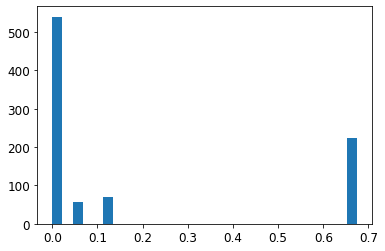

In [30]:
plt.hist(dtc_tuned.predict_proba(X2_test)[:, 1], bins = 30)
plt.show()

In [33]:
y2_pred_imb = dtc_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_imb))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       471
           1       1.00      0.53      0.70       420

    accuracy                           0.78       891
   macro avg       0.85      0.77      0.76       891
weighted avg       0.84      0.78      0.77       891



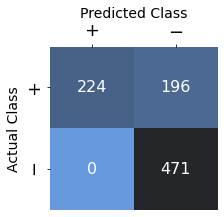

In [34]:
cm = confusion_matrix(y2_test, y2_pred_imb, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

As expected the classifier is biased toward the negative class. Let's try to use some imbalanced technique in order to enhance the performances.

#### Oversampling

##### SMOTE

In [35]:
y2_train_imb.value_counts()

0    1073
1      44
Name: 0, dtype: int64

Here, SMOTE for each record belonging to the minority class generates 1073/44 new artificial records. Each new record is produced by means of a linear combination with one randomly selected nearest neighbor.

In [36]:
smote = SMOTE(k_neighbors = 5, random_state = 5) 
X2_train_res, y2_train_res = smote.fit_resample(X2_train_imb, y2_train_imb.values)

In [37]:
X2_train_res.shape, y2_train_res.shape

((2146, 561), (2146,))

In [38]:
np.unique(y2_train_res, return_counts = True)

(array([0, 1], dtype=int64), array([1073, 1073], dtype=int64))

In [39]:
# SMOTE, w/o tuning

dtc_smote = DTC().fit(X2_train_res, y2_train_res)

In [40]:
y2_pred_res = dtc_smote.predict(X2_test)
print(classification_report(y2_test, y2_pred_res))

              precision    recall  f1-score   support

           0       0.69      0.97      0.81       471
           1       0.94      0.52      0.67       420

    accuracy                           0.76       891
   macro avg       0.81      0.74      0.74       891
weighted avg       0.81      0.76      0.74       891



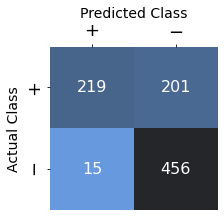

In [41]:
cm = confusion_matrix(y2_test, y2_pred_res, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

With respect to imbalanced classification, the SMOTE technique predicts more frequently positive and also reduces false negative predictions. False positive predictions increase moderately.

---

In [315]:
# SMOTE, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10,
                           n_jobs = -1,
                           scoring = 'f1')

In [316]:
grid_search.fit(X2_train_res, y2_train_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='f1')

In [317]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 25, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 30, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 35, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.956 (std: 0.054)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 40, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score:

In [42]:
dtc_smote_tuned = DTC(max_depth = 4, max_leaf_nodes = 10, 
                      min_samples_leaf = 30).fit(X2_train_res, y2_train_res)

In [149]:
y2_pred_smote_tuned = dtc_smote_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_res))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       471
           1       0.93      0.65      0.76       420

    accuracy                           0.81       891
   macro avg       0.84      0.80      0.80       891
weighted avg       0.84      0.81      0.80       891



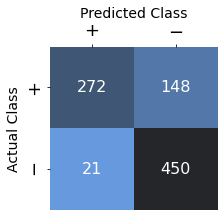

In [150]:
cm = confusion_matrix(y2_test, y2_pred_smote_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The classifier after the tuning step improves significantly its performances on the negative class without make worsening the predictions of the positive one.

---

##### ADASYN

ADASYN is very similar to SMOTE the only difference is that instead to produce the same number of artificial records for each actual point of the minority class, the minority records that in their neighborhood have more objects belonging to the majority class (and thus are "harder-to-learn"), produce more artificial instances.

In [45]:
adasyn = ADASYN(random_state = 5, n_neighbors = 3, n_jobs = -1)
X2_adasyn_res, y2_adasyn_res = adasyn.fit_resample(X2_train_imb, y2_train_imb.values)

In [46]:
np.unique(y2_adasyn_res, return_counts = True)

(array([0, 1], dtype=int64), array([1073, 1066], dtype=int64))

In [47]:
# ADASYN, w/o tuning

dtc_adasyn = DTC(random_state = 5).fit(X2_adasyn_res, y2_adasyn_res)

In [48]:
y2_pred_adasyn = dtc_adasyn.predict(X2_test)
print(classification_report(y2_test, y2_pred_adasyn))

              precision    recall  f1-score   support

           0       0.70      0.98      0.82       471
           1       0.96      0.53      0.68       420

    accuracy                           0.77       891
   macro avg       0.83      0.75      0.75       891
weighted avg       0.82      0.77      0.75       891



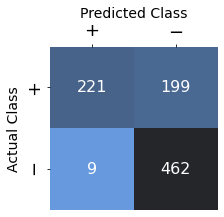

In [49]:
cm = confusion_matrix(y2_test, y2_pred_adasyn, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [379]:
# ADASYN, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10,
                           n_jobs = -1,
                           scoring = 'f1')

In [380]:
grid_search.fit(X2_adasyn_res, y2_adasyn_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='f1')

In [381]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 25, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 30, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 35, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score: 0.954 (std: 0.043)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 40, 'min_samples_leaf': 50}

Model with rank: 1
Mean validation score:

In [50]:
dtc_adasyn_tuned = DTC(max_depth = 4, max_leaf_nodes = 10, 
                      min_samples_leaf = 50).fit(X2_adasyn_res, y2_adasyn_res)

In [156]:
y2_pred_adasyn_tuned = dtc_adasyn_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_adasyn))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       471
           1       0.93      0.64      0.76       420

    accuracy                           0.81       891
   macro avg       0.84      0.80      0.80       891
weighted avg       0.83      0.81      0.80       891



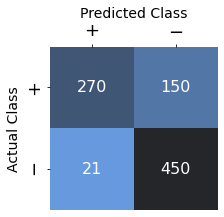

In [157]:
cm = confusion_matrix(y2_test, y2_pred_adasyn_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

In this imbalanced scenario, this algorithm obtained the best performaces.

#### Undersampling

##### Random undersampling

In [53]:
under = RandomUnderSampler(random_state = 5)
X2_under_res, y2_under_res = under.fit_resample(X2_train_imb, y2_train_imb.values)

In [54]:
np.unique(y2_under_res, return_counts = True)

(array([0, 1], dtype=int64), array([44, 44], dtype=int64))

The train set contains only 44 instances

In [55]:
# undersampling, w/o tuning

dtc_under = DTC(random_state = 5).fit(X2_under_res, y2_under_res)

In [56]:
y2_pred_under = dtc_under.predict(X2_test)
print(classification_report(y2_test, y2_pred_under))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       471
           1       0.82      0.84      0.83       420

    accuracy                           0.84       891
   macro avg       0.84      0.84      0.84       891
weighted avg       0.84      0.84      0.84       891



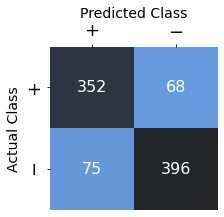

In [57]:
cm = confusion_matrix(y2_test, y2_pred_under, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [327]:
# undersampling, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10,
                           n_jobs = -1,
                           scoring = 'f1')

In [328]:
grid_search.fit(X2_under_res, y2_under_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='f1')

In [329]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.989 (std: 0.033)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score:

In [58]:
dtc_under_tuned = DTC(max_depth = 4, max_leaf_nodes = 10, 
                      min_samples_leaf = 25).fit(X2_under_res, y2_under_res)

In [158]:
y2_pred_under_tuned = dtc_under_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_under))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       471
           1       0.93      0.75      0.83       420

    accuracy                           0.86       891
   macro avg       0.87      0.85      0.85       891
weighted avg       0.87      0.86      0.85       891



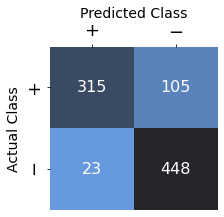

In [159]:
cm = confusion_matrix(y2_test, y2_pred_under_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The random undersampling technique produces better results comparing to SMOTE, in spite of the vary small train set. This might depend on three factors: the test set is balanced; the undersampling technique does not produce artificial instances; WALKING DOWNSTAIRS and UPSTAIRS are well distinguish activities and the classifier does not need many instances to build a reliable model.

---

##### CNN

1. Get all minority samples in a set C.

2. Add a sample from the targeted class (class to be under-sampled) in C and all other samples of this class in a set S.

3. Go through the set S, sample by sample, and classify each sample using a 1 nearest neighbor rule.

4. If the sample is misclassified, add it to C, otherwise do nothing.

5. Reiterate on S until there is no samples to be added.

In [61]:
cnn = CondensedNearestNeighbour(random_state = 5, n_jobs = -1)
X_cnn_res, y_cnn_res = cnn.fit_resample(X2_train_imb, y2_train_imb.values)

In [62]:
np.unique(y_cnn_res, return_counts = True)

(array([0, 1], dtype=int64), array([39, 44], dtype=int64))

The CNN does not always produce class with the same cardinality

In [63]:
# CNN, w/o tuning

dtc_cnn = DTC(random_state = 5).fit(X_cnn_res, y_cnn_res)

In [64]:
y2_pred_cnn = dtc_cnn.predict(X2_test)
print(classification_report(y2_test, y2_pred_cnn))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       471
           1       0.77      0.71      0.74       420

    accuracy                           0.76       891
   macro avg       0.76      0.76      0.76       891
weighted avg       0.76      0.76      0.76       891



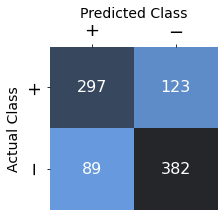

In [65]:
cm = confusion_matrix(y2_test, y2_pred_cnn, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [356]:
# CNN, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10,
                           n_jobs = -1,
                           scoring = 'f1')

In [357]:
grid_search.fit(X_cnn_res, y_cnn_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='f1')

In [358]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.877 (std: 0.110)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score:

In [68]:
dtc_cnn_tuned = DTC(max_depth = 4, max_leaf_nodes = 10, 
                      min_samples_leaf = 25).fit(X_cnn_res, y_cnn_res)

In [147]:
y2_pred_cnn_tuned = dtc_cnn_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_cnn))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       471
           1       0.97      0.67      0.79       420

    accuracy                           0.84       891
   macro avg       0.87      0.83      0.83       891
weighted avg       0.87      0.84      0.83       891



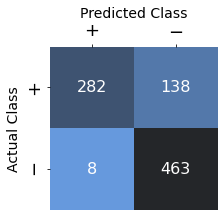

In [70]:
cm = confusion_matrix(y2_test, y2_pred_cnn_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

The bad performances of CNN with hyperparameter tuning might depend on the small cardinality of the training set. Indeed, the parameter ranges are not compatible with only 44 records. 

---

##### TomekLinks

TomekLinks performs an undersampling by removing the object belonging to majority class of each Tomek’s link. A Tomek’s link is when two record belong to different classes and they both are the 1-nearest neighbor of each other (that is, in the train set there are no other points closer to any of the two points).

In [71]:
tomek = TomekLinks(n_jobs = -1)
X_tomek_res, y_tomek_res = tomek.fit_resample(X2_train_imb, y2_train_imb.values)

In [72]:
np.unique(y_tomek_res, return_counts = True)

(array([0, 1], dtype=int64), array([1073,   44], dtype=int64))

The method doesn't resample the data. This might mean that the 1-NN of each point is an object belonging to the same class.

---

##### Meta-Cost Sensitive Classifier

We are interested in predicting the positive class thus we have to put more weight on false negative predictions. However, if we put weight only on the FN predictions, the classifier predicts always the positive class. Therefore we need to penalize also the FP

In [73]:
fp, fn, tp, tn = 1, 10, 0, 0
cost_mtx = [fp, fn, tp, tn] * y2_train_imb.size
cost_mtx = np.array(cost_mtx).reshape(-1, 4)

In [74]:
cost_mtx

array([[ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       ...,
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0]])

In [75]:
X2_train_imb.shape, cost_mtx.shape

((1117, 561), (1117, 4))

In [76]:
'''
I don't know whether this algorithm can be tuned with GridSearchCV, but
even if it was, it is very inefficient and it would take too much time. 
Therfore, I pass the optimal hyperparameters tuned for the DTC.
'''

csdtc = CSDTC() #max_depth = 4, min_samples_leaf = 45
csdtc.fit(X2_train_imb.values, y2_train_imb.values, cost_mtx)
y2_pred_costmtx = csdtc.predict(X2_test.values)

In [77]:
print(classification_report(y2_test, y2_pred_costmtx))

              precision    recall  f1-score   support

           0       0.74      0.98      0.85       471
           1       0.97      0.62      0.75       420

    accuracy                           0.81       891
   macro avg       0.85      0.80      0.80       891
weighted avg       0.85      0.81      0.80       891



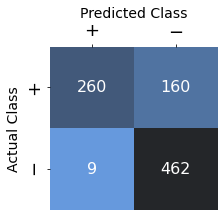

In [78]:
cm = confusion_matrix(y2_test, y2_pred_costmtx, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)
# plt.savefig('meta_cost_1,5,-1,0.pdf', format = 'pdf')

In [79]:
# Savings of a using y_pred on y_true with cost-matrix cost-mat.
# The best performance is 1.

cost_mtx_test = cost_mtx[: X2_test.shape[0]]
savings_score(y2_test, y2_pred_costmtx, cost_mtx_test)

-2.416135881104034

In [80]:
# y2_pred_imb are the predicted classes of the pure and not tuning DTC

savings_score(y2_test, y2_pred_imb, cost_mtx_test)

-3.1613588110403397

---

Observation: by looking at the accelerometer graph it is evident that the WALKING DOWNSTAIRS activity is characterized by a higher variance than WALKING UPSTAIRS. This can be shown from the two histograms below obtained by selecting a subgroup of features that measure the standard deviation of the acceleration signal. Therefore, based on the mean of these features, we can assign a cost to each record based on its mean with respect to these variables: higher is the mean, higher is the cost attributed to FN predictions.

In [81]:
df2 = pd.concat((X2_train_imb, y2_train_imb), axis = 1, ignore_index = True)
df2 = df2[[3,83,201,214,227,268,347,503,516,561]]

In [82]:
df2.groupby(561).mean()

,3,83,201,214,227,268,347,503,516
561,,,,,,,,,
0,-0.221072,-0.355849,-0.235552,-0.235552,-0.387353,-0.198616,-0.384103,-0.349171,-0.439910
1,0.110146,0.019936,0.133427,0.133427,0.036570,0.115648,-0.036834,-0.075313,-0.027551


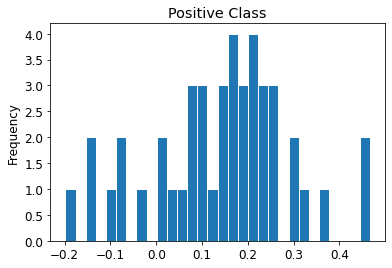

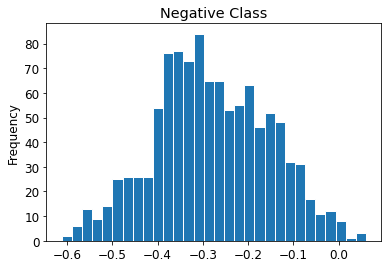

In [83]:
df2.loc[df2[561]==1].mean(axis = 1).plot.hist(bins = 30, edgecolor = 'w')
plt.title('Positive Class')
plt.show()

df2.loc[df2[561]==0].mean(axis = 1).plot.hist(bins = 30, edgecolor = 'w')
plt.title('Negative Class')
plt.show()

In [84]:
mask = df2.mean(axis = 1) > 0
weight_idx = set(X2_train_imb[mask].index)

In [85]:
cost_mtx = [] 
for idx in X2_train_imb.index:
    if idx in weight_idx:
        cost_mtx.append([1, 10, 0, 0])
    else:
        cost_mtx.append([10, 1, 0, 0])
        
cost_mtx = np.array(cost_mtx)

In [86]:
cost_mtx.shape

(1117, 4)

In [87]:
for row in cost_mtx:
    print(row)

[10  1  0  0]
[ 1 10  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[ 1 10  0  0]
[ 1 10  0  0]
[10  1  0  0]
[ 1 10  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1

[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[ 1 10  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1  0  0]
[10  1

In [88]:
csdtc_custom = CSDTC()
csdtc_custom.fit(X2_train_imb.values, y2_train_imb.values, cost_mtx)
y2_pred_costmtx_custom = csdtc_custom.predict(X2_test.values)

In [89]:
print(classification_report(y2_test, y2_pred_costmtx_custom))

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       471
           1       1.00      0.43      0.60       420

    accuracy                           0.73       891
   macro avg       0.83      0.71      0.70       891
weighted avg       0.82      0.73      0.70       891



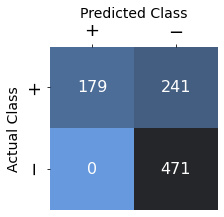

In [90]:
cm = confusion_matrix(y2_test, y2_pred_costmtx_custom, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

##### Class Weight 

In [91]:
''' class_weight="balanced" implicitly replicates the smaller class until 
it reaches the cardinality of the larger one.
'''

dtc_cw = DTC(class_weight = 'balanced', random_state = 5)
dtc_cw.fit(X2_train_imb.values, y2_train_imb.values)

DecisionTreeClassifier(class_weight='balanced', random_state=5)

In [92]:
y2_pred_cw = dtc_cw.predict(X2_test.values)

In [93]:
print(classification_report(y2_test, y2_pred_cw))

              precision    recall  f1-score   support

           0       0.65      0.99      0.79       471
           1       0.96      0.42      0.58       420

    accuracy                           0.72       891
   macro avg       0.81      0.70      0.68       891
weighted avg       0.80      0.72      0.69       891



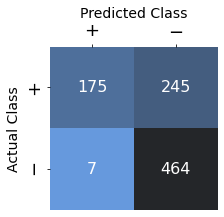

In [94]:
cm = confusion_matrix(y2_test, y2_pred_cw, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

In [190]:
# Class Weight, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(class_weight = 'balanced', random_state = 5), 
                           param_grid = param, cv = 10, 
                           scoring = 'f1') # f1 is a good measure with class imbalance

In [191]:
grid_search.fit(X2_train_imb.values, y2_train_imb.values)
dtc_cw_tuned = grid_search.best_estimator_
dtc_cw_tuned

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=10,
                       min_samples_leaf=35, random_state=5)

In [192]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 15, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 25, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 30, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 35, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.654 (std: 0.248)
Parameters: {'max_depth': 4, 'max_leaf_nodes': 40, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score:

In [95]:
dtc_cw_tuned = DTC(class_weight = 'balanced', max_depth = 4, 
                   max_leaf_nodes = 10, min_samples_leaf = 25, 
                   random_state = 5)
dtc_cw_tuned.fit(X2_train_imb.values, y2_train_imb.values)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=10,
                       min_samples_leaf=25, random_state=5)

In [96]:
y2_pred_cw_tuned = dtc_cw_tuned.predict(X2_test)
print(classification_report(y2_test, y2_pred_cw_tuned))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       471
           1       0.85      0.77      0.81       420

    accuracy                           0.83       891
   macro avg       0.83      0.82      0.83       891
weighted avg       0.83      0.83      0.83       891



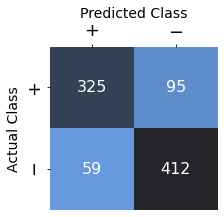

In [97]:
cm = confusion_matrix(y2_test, y2_pred_cw_tuned, labels = [1, 0])
plot_confusion_mtx(cm, [], binary = True)

---

#### Comparison among imbalanced techniques

For comparisons let's consider only tuned classifiers

In [139]:
classifiers = [dtc_tuned, dtc_under_tuned, dtc_cnn_tuned, 
               dtc_smote_tuned, dtc_adasyn_tuned, dtc_cw_tuned]
labels = 'Simple RandomUnder. CNN SMOTE ADASYN CostWeight'.split()

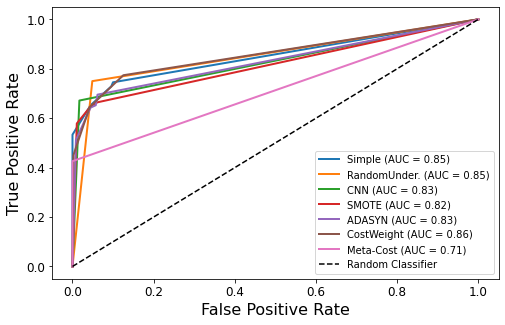

In [140]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
for i, cls in enumerate(classifiers):
    roc = RocCurveDisplay.from_estimator(cls, X2_test, y2_test, ax = ax, 
                                        name = labels[i], lw = 2)
RocCurveDisplay.from_predictions(y2_test, y2_pred_costmtx_custom, ax = ax,
                                    lw = 2, name = 'Meta-Cost')
random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', 
                 label = 'Random Classifier')
ax.legend(fontsize = 'small')
ax.set_ylabel('True Positive Rate', fontsize = 16)
ax.set_xlabel('False Positive Rate', fontsize = 16)
plt.show()

Except the meta-cost sensitive classifier, all the others perform very similarly to the model that does not use any imbalanced techniques. 

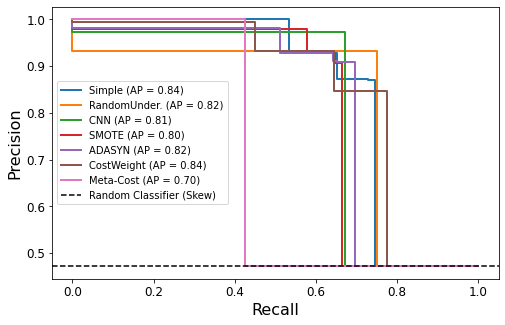

In [141]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
for i, cls in enumerate(classifiers):
    roc = PrecisionRecallDisplay.from_estimator(cls, X2_test, y2_test, ax = ax, 
                                        name = labels[i], lw = 2)
PrecisionRecallDisplay.from_predictions(y2_test, y2_pred_costmtx_custom, 
                                        ax = ax, lw = 2, name = 'Meta-Cost')    
random = ax.axhline(y = (y2_test.sum() / y2_test.size), ls = '--', 
                    color = 'k', label = 'Random Classifier (Skew)')
ax.legend(fontsize = 'small')
ax.set_ylabel('Precision', fontsize = 16)
ax.set_xlabel('Recall', fontsize = 16)
plt.show()

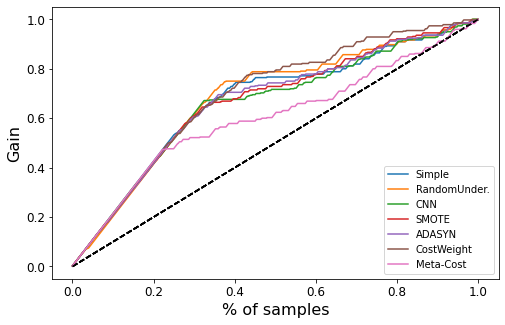

In [339]:
plt.figure(figsize = (8, 5))
for i, cls in enumerate(classifiers):
    pred = cls.predict_proba(X2_test.values)[:,1]
    plot_gains_curve(y2_test.values, pred, labels[i])
pred = csdtc_custom.predict_proba(X2_test.values)[:,1]
plot_gains_curve(y2_test.values, pred, 'Meta-Cost')
plt.legend(loc = 'lower right')
plt.show()

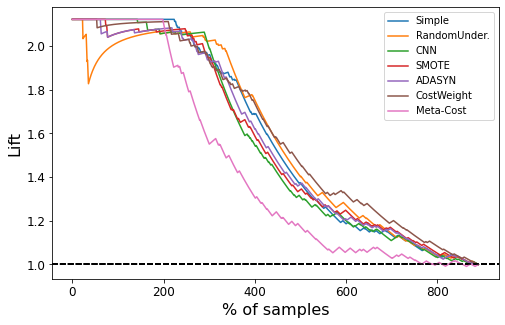

In [341]:
plt.figure(figsize = (8, 5))
for i, cls in enumerate(classifiers):
    pred = cls.predict_proba(X2_test.values)[:,1]
    plot_lift(y2_test.values, pred, labels[i])
pred = csdtc_custom.predict_proba(X2_test.values)[:,1]
plot_lift(y2_test.values, pred, 'Meta-Cost')
plt.legend(loc = 'upper right')
plt.show()

---

#### Improve classification performances using dimensionality reduction

### 3)

In [13]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [14]:
y_train[0].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: 0, dtype: int64

Let's unbalance the WALKING DOWNSTAIRS and perform a multiclass classification.

In [17]:
# let's extract only 50 records of the WALKING DOWNSTAIRS class

mask = y_train[0] == 3
walk_down_idx = y_train[0][mask].index
residual_idx = y_train[0][~mask].index
samp_idx = generator.choice(walk_down_idx, 50, replace = False)
final_idx = np.sort(np.hstack((residual_idx, samp_idx)))
X3_train_res, y3_train_res = X_train.loc[final_idx], y_train.loc[final_idx]

In [18]:
X3_train_res.shape, y3_train_res.shape

((6416, 561), (6416, 1))

In [19]:
y3_train_res[0].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3      50
Name: 0, dtype: int64

In [398]:
# imbalance, w/o tuning

clf = DTC(random_state = 5).fit(X3_train_res, y3_train_res)

In [399]:
y3_pred = clf.predict(X_test)

In [405]:
print(classification_report(y_test, y3_pred, 
                            target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.66      0.73      0.69       496
  WALKING_UPSTAIRS       0.58      0.80      0.67       471
WALKING_DOWNSTAIRS       0.97      0.44      0.61       420
           SITTING       0.82      0.75      0.78       491
          STANDING       0.79      0.85      0.82       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.77      2947
         macro avg       0.80      0.76      0.76      2947
      weighted avg       0.80      0.77      0.77      2947



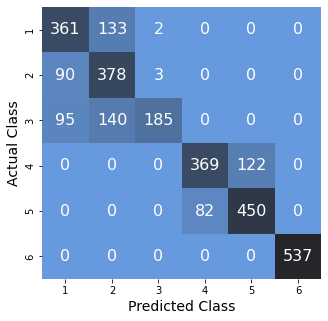

In [404]:
cm = confusion_matrix(y_test, y3_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

---

For multiclass classification we cannot use the f1 score

https://stats.stackexchange.com/questions/431022/error-while-performing-multiclass-classification-using-gridsearch-cv

In [415]:
f1 = make_scorer(f1_score , average='weighted')

In [416]:
# imbalance, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10,
                           n_jobs = -1,
                           scoring = f1)

In [417]:
grid_search.fit(X3_train_res, y3_train_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring=make_scorer(f1_score, average=weighted))

In [418]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.887 (std: 0.053)
Parameters: {'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.887 (std: 0.053)
Parameters: {'max_depth': 7, 'max_leaf_nodes': 35, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.887 (std: 0.053)
Parameters: {'max_depth': 7, 'max_leaf_nodes': 40, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.887 (std: 0.053)
Parameters: {'max_depth': 7, 'max_leaf_nodes': 45, 'min_samples_leaf': 30}

Model with rank: 1
Mean validation score: 0.887 (std: 0.053)
Parameters: {'max_depth': 7, 'max_leaf_nodes': 50, 'min_samples_leaf': 30}



In [419]:
y3_pred = grid_search.predict(X_test)

In [420]:
print(classification_report(y_test, y3_pred, 
                            target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.58      0.76      0.66       496
  WALKING_UPSTAIRS       0.59      0.71      0.65       471
WALKING_DOWNSTAIRS       0.99      0.39      0.55       420
           SITTING       0.80      0.80      0.80       491
          STANDING       0.82      0.82      0.82       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.76      2947
         macro avg       0.80      0.75      0.75      2947
      weighted avg       0.80      0.76      0.76      2947



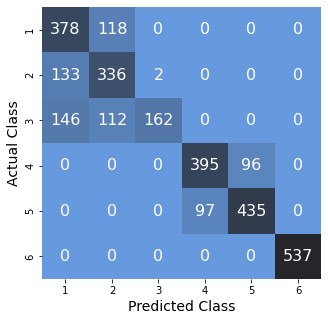

In [421]:
cm = confusion_matrix(y_test, y3_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

The classifier does not predict WALKING DOWN very often but when it does it hits the nail on the head (high precision). On the other hand, it fails to distinguish it when it actually occurs, incorrectly predicting it as one of the other two movement activities (very poor recall).

---

Let's try some imbalance techniques.

##### ADASYN

In [424]:
# we only preform the oversamplig of the minority class

adasyn = ADASYN(random_state = 5, n_neighbors = 3, 
                sampling_strategy = 'minority', n_jobs = -1)
X3_adasyn_res, y3_adasyn_res = adasyn.fit_resample(X3_train_res, y3_train_res)

In [425]:
np.unique(y3_adasyn_res, return_counts = True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([1226, 1073, 1401, 1286, 1374, 1407], dtype=int64))

In [426]:
# ADASYN, w/o tuning

clf = DTC(random_state = 5).fit(X3_adasyn_res, y3_adasyn_res)

In [429]:
y3_pred_adasyn = clf.predict(X_test)
print(classification_report(y_test, y3_pred_adasyn,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.67      0.79      0.73       496
  WALKING_UPSTAIRS       0.67      0.76      0.71       471
WALKING_DOWNSTAIRS       0.97      0.62      0.76       420
           SITTING       0.82      0.75      0.78       491
          STANDING       0.79      0.85      0.82       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.80      2947
         macro avg       0.82      0.80      0.80      2947
      weighted avg       0.82      0.80      0.80      2947



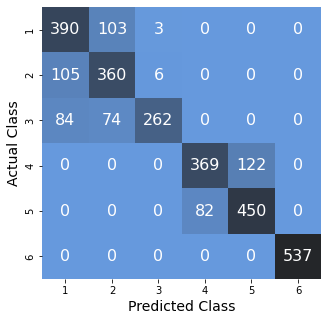

In [432]:
cm = confusion_matrix(y_test, y3_pred_adasyn, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

---

In [434]:
# ADASYN, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [435]:
grid_search.fit(X3_adasyn_res, y3_adasyn_res)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='accuracy')

In [436]:
y3_adasyn_pred = grid_search.predict(X_test)
print(classification_report(y_test, y3_adasyn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.73      0.80      0.77       496
  WALKING_UPSTAIRS       0.65      0.77      0.70       471
WALKING_DOWNSTAIRS       0.96      0.64      0.77       420
           SITTING       0.80      0.81      0.80       491
          STANDING       0.82      0.81      0.82       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.81      2947
         macro avg       0.83      0.81      0.81      2947
      weighted avg       0.83      0.81      0.81      2947



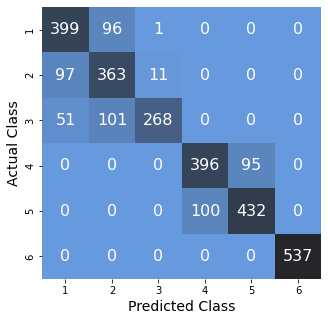

In [437]:
cm = confusion_matrix(y_test, y3_adasyn_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

##### CNN

In [441]:
cnn = CondensedNearestNeighbour(random_state = 5, n_jobs = -1)
X3_cnn_res, y3_cnn_res = cnn.fit_resample(X3_train_res, y3_train_res)

In [449]:
y3_cnn_res.value_counts()

3    50
2    44
1    36
4     4
6     4
5     2
dtype: int64

In [442]:
clf = DTC(random_state = 5).fit(X3_cnn_res, y3_cnn_res)

In [443]:
y3_cnn_pred = clf.predict(X_test)
print(classification_report(y_test, y3_cnn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.79      0.72      0.76       496
  WALKING_UPSTAIRS       0.58      0.73      0.65       471
WALKING_DOWNSTAIRS       0.76      0.79      0.77       420
           SITTING       0.53      0.58      0.55       491
          STANDING       0.49      0.63      0.56       532
            LAYING       0.54      0.25      0.34       537

          accuracy                           0.61      2947
         macro avg       0.62      0.62      0.60      2947
      weighted avg       0.61      0.61      0.60      2947



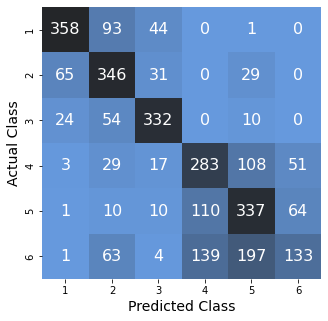

In [444]:
cm = confusion_matrix(y_test, y3_cnn_pred, labels = clf.classes_)
plot_confusion_mtx(cm, clf.classes_, figsize = (5, 5), binary = False)

---

The CNN selects only very few records for the movement classes. For this reason, it is not possible to tune the parameters (an error is raised).

In [452]:
# CNN w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 5,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [453]:
grid_search.fit(X3_cnn_res, y3_cnn_res)

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='accuracy')

In [454]:
y3_cnn_pred = grid_search.predict(X_test)
print(classification_report(y_test, y3_cnn_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.33      0.95      0.49       496
  WALKING_UPSTAIRS       0.28      0.78      0.41       471
WALKING_DOWNSTAIRS       0.97      0.48      0.64       420
           SITTING       0.00      0.00      0.00       491
          STANDING       0.00      0.00      0.00       532
            LAYING       0.00      0.00      0.00       537

          accuracy                           0.35      2947
         macro avg       0.26      0.37      0.26      2947
      weighted avg       0.24      0.35      0.24      2947



C:\Users\simon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


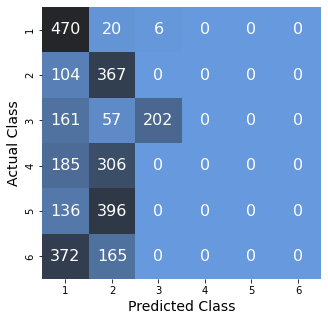

In [455]:
cm = confusion_matrix(y_test, y3_cnn_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

---

##### Random undersampling

In [459]:
under = RandomUnderSampler(sampling_strategy = 'not minority', random_state = 5)
X3_under_res, y3_under_res = under.fit_resample(X3_train_res, y3_train_res)

In [460]:
y3_under_res.value_counts()

1    50
2    50
3    50
4    50
5    50
6    50
dtype: int64

In [462]:
# CNN, w tuning

param = {'max_depth': list(range(4,8)),
         'min_samples_leaf': list(range(25, 61, 5)),
         'max_leaf_nodes': list(range(10, 51, 5))}

grid_search = GridSearchCV(DTC(random_state = 5), 
                           param_grid = param, cv = 10,
                           n_jobs = -1,
                           scoring = 'accuracy')

In [463]:
grid_search.fit(X3_under_res, y3_under_res)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=5), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'min_samples_leaf': [25, 30, 35, 40, 45, 50, 55, 60]},
             scoring='accuracy')

In [464]:
y3_under_pred = grid_search.predict(X_test)
print(classification_report(y_test, y3_under_pred,
                           target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.62      0.67      0.64       496
  WALKING_UPSTAIRS       0.47      0.58      0.52       471
WALKING_DOWNSTAIRS       0.95      0.64      0.77       420
           SITTING       0.79      0.80      0.80       491
          STANDING       0.82      0.80      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.76      2947
         macro avg       0.78      0.75      0.76      2947
      weighted avg       0.78      0.76      0.76      2947



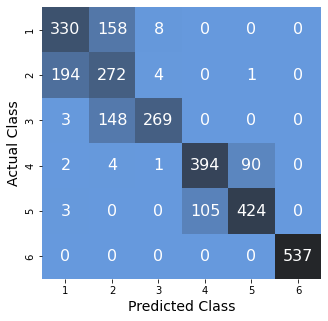

In [465]:
cm = confusion_matrix(y_test, y3_under_pred, labels = grid_search.classes_)
plot_confusion_mtx(cm, grid_search.classes_, figsize = (5, 5), binary = False)

---